## IMERG Data `Exploration` & `Plotting`

* The aim of this notebook is to plot and create patches from a single IMERG tile and plot a sequence of imerg inputs and targets 

In [16]:
import math
import os
import re

import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import h5py
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from scipy import io
import xarray as xr
from PIL import Image

from rainnow.src.utilities.utils import (
    calculate_required_1d_padding,
)
from rainnow.src.data_prep.data_processing import (
    patch_2d_arr_into_nxn_squares,
    create_square_patches_from_2d_arr_using_mirror_padding,
    load_imerg_h5_file_into_xarr,
    crop_xarr_using_lat_and_lon,
)
from rainnow.src.plotting import (
    plot_raw_imerg_xarray_tile,
    geoplot_raw_imerg_xarray_tile,
    add_bounding_box_to_plot,
    add_patch_to_geoplot,
    add_patch_to_plot,
    plot_single_patched_imerg_grid,
)
from rainnow.src.configs.config import (
    IMERG_CROP,
    PATCH_SIZE,
    IMERG_PIXEL_RES,
    DOWNLOAD_DIR,
    GPM_API_DOWNLOAD_DIR_STRUCTURE,
    CROP_DIMS,
    IMERGEarlyRunConfig,
)

#### `Helpers.`

In [ ]:
# ** dir helpers **
BASE_PATH = "/teamspace/studios/this_studio"

# load in custom colour map.
cmap = io.loadmat(f"{BASE_PATH}/DYffcast/rainnow/src/utilities/cmaps/colormap.mat")
# cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
box_params = {"color": "red", "linestyle": "--", "linewidth": 1}
rain_cmap = ListedColormap(cmap["Cmap_rain"])

#### `Load in IMERG image`

In [ ]:
# ** local paths **
# # Jan 2020 - 23/24 Brazil
# file_path = "data/imerg/V07/2020/01/"

# Sept 2022 27 Hurricane Ian (Florida)
file_path = "/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2022/09/27/3B-HHR-E.MS.MRG.3IMERG.20220927-S200000-E202959.1200.V07B.RT-H5"

# cyclone YUKA - chosen visual case study --> effects Ecuador, Peru and North-Western
# file_path = "/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2023/03/09/3B-HHR-E.MS.MRG.3IMERG.20230309-S030000-E032959.0180.V07B.RT-H5"

imerg_tile = load_imerg_h5_file_into_xarr(file_path=file_path)
imerg_tile = crop_xarr_using_lat_and_lon(
    xarr=imerg_tile, lat_lims=(-89.95, 89.95), lon_lims=(-179.95, 179.95)
)
print(imerg_tile.shape)

(1800, 3600)


In [19]:
# ** south america crop lims **
lat_lims = IMERG_CROP["inner"]["latitude"]
lon_lims = IMERG_CROP["inner"]["longitude"]
patch_size = PATCH_SIZE
lat_lims, lon_lims

((-59.85, 16.85), (-83.55, -32.45))

### Plots
* non-geo plots so there are no coastlines / land features.

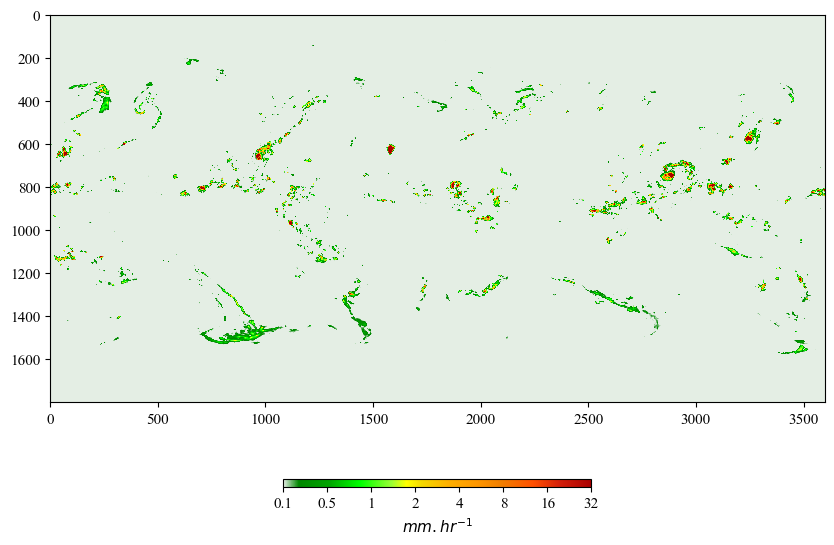

In [20]:
# plot raw imerg tile.
fig, ax = plot_raw_imerg_xarray_tile(
    imerg_tile=np.flipud(imerg_tile),
    plot_params={"cmap": rain_cmap, "vmin": 1, "vmax": 8, "origin": "upper"},
    cbar_params={
        "orientation": "horizontal",
        "pad": 0.1,
        "fraction": 0.01,
        "aspect": 40,
    },
    global_params={
        "font.size": 11,
        "font.family": "Times New Roman",
    },
)

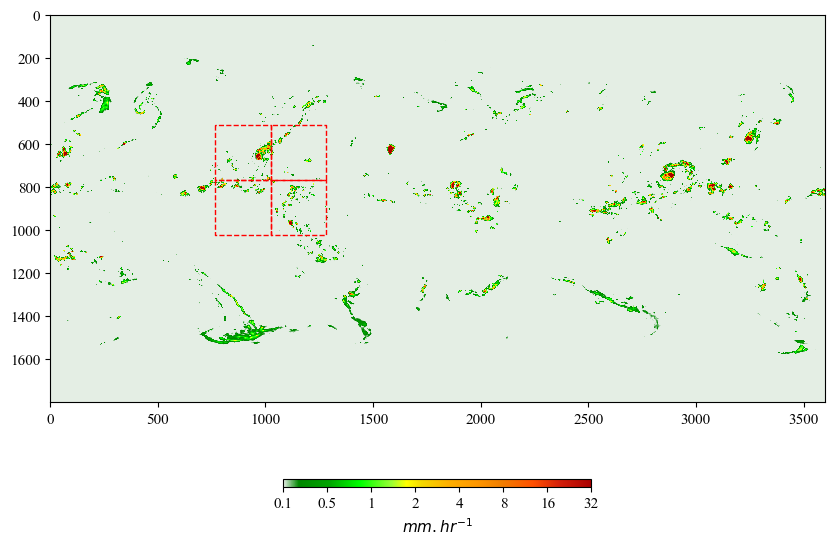

In [21]:
# add 256x256 patches to the IMERG tile.
box_params = {"color": "red", "linestyle": "--", "linewidth": 1}
add_patch_to_plot(ax=ax, patch_size=256, nx=3, ny=2, box_params=box_params)
add_patch_to_plot(ax=ax, patch_size=256, nx=4, ny=2, box_params=box_params)
add_patch_to_plot(ax=ax, patch_size=256, nx=3, ny=3, box_params=box_params)
add_patch_to_plot(ax=ax, patch_size=256, nx=4, ny=3, box_params=box_params)

fig

### Geoplots
* includes coastlines and land features i.e. lakes

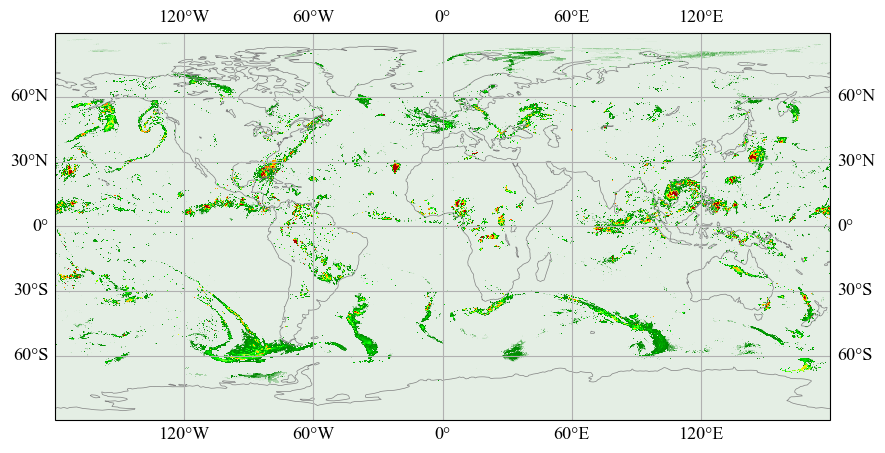

In [22]:
# plot the raw imerg tile but with geo features.
fig, ax = geoplot_raw_imerg_xarray_tile(
    imerg_tile=imerg_tile,
    projection=ccrs.PlateCarree(),
    plot_params={"cmap": rain_cmap, "vmin": 0.1, "vmax": 8, "alpha": 1},
    cbar_params=None,
    global_params={
        "font.size": 13,
        "font.family": "Times New Roman",
    },
    geo_params={"linewidth": 0.5},
)

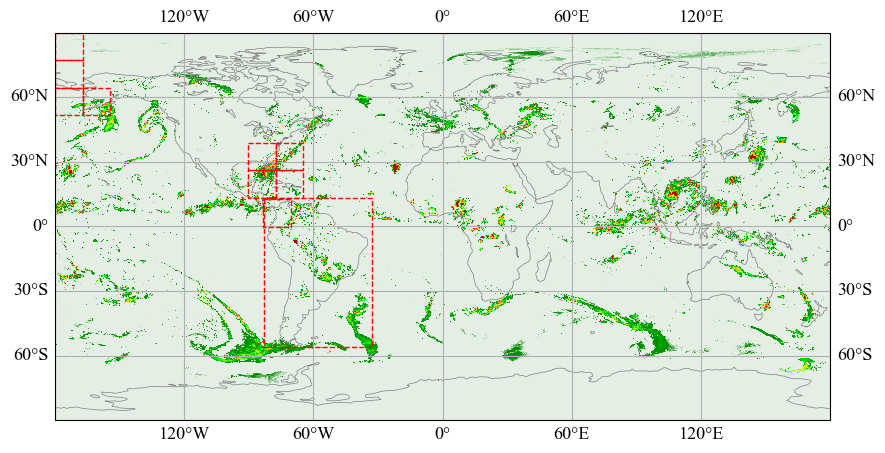

In [23]:
# # add bounding box.
# add_bounding_box_to_plot(
#     ax=ax,
#     # xs=[-120, 0, 0, -120, -120],
#     # ys=[59.95, 59.95, -59.95, -59.95, 59.95]
#     # wider SA crop.
#     xs=[-99.95, -20.05, -20.05, -99.95, -99.95],
#     ys=[39.95, 39.95, -59.95, -59.95, 39.95],
#     box_params={'color': 'red', 'linestyle': '-', 'linewidth': 1},
# )

# add bounding box.
add_bounding_box_to_plot(
    ax=ax,
    # SA crop.
    xs=[-83, -33, -33, -83, -83],
    ys=[13, 13, -56, -56, 13],
    box_params=box_params,
)


for nx, ny in [
    (0, 0),
    (0, 1),
    (0, 2),
    (1, 2),
    (7, 4),
    (7, 5),
    (8, 4),
    (8, 5),
    (7.55, 6.05),
]:
    add_patch_to_geoplot(
        ax,
        patch_size=PATCH_SIZE,
        lat_pixel_resolution=IMERG_PIXEL_RES,
        lon_pixel_resolution=IMERG_PIXEL_RES,
        top_left_lon_lat=(
            # IMERG_CROP["inner"]["longitude"][0], IMERG_CROP["inner"]["latitude"][-1],
            (-179.95, 89.95)
        ),  # (longitude, latitude)
        nx=nx,
        ny=ny,
        box_params=box_params,
    )
fig

### creating 256x256 patches from the IMERG tile:

In [24]:
x_pad = calculate_required_1d_padding(X=imerg_tile.shape[1], Y=patch_size, frac=0)
y_pad = calculate_required_1d_padding(X=imerg_tile.shape[0], Y=patch_size, frac=0)

print(x_pad, y_pad)

imerg_patches = patch_2d_arr_into_nxn_squares(
    arr2d=imerg_tile,
    n=patch_size,
    x_pad=x_pad,
    y_pad=y_pad,
    flip_pixels=True,
)

imerg_patches.shape

112 120


(15, 29, 128, 128)

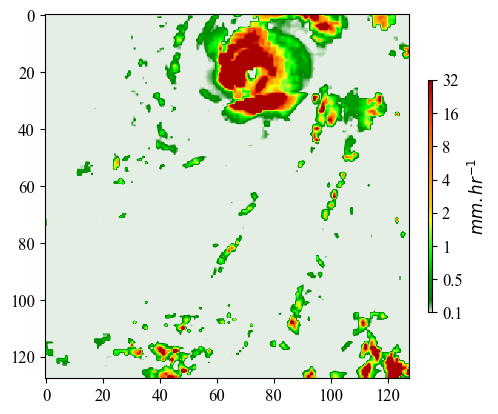

In [25]:
# plot raw imerg tile.
fig, ax = plot_raw_imerg_xarray_tile(
    # imerg_tile=imerg_patches[3, 4],
    imerg_tile=imerg_patches[5, 7],  # go outside of box to get hurricane ian.
    plot_params={"cmap": rain_cmap, "vmin": 1, "vmax": 8, "origin": "upper"},
    cbar_params={
        "orientation": "vertical",
        "pad": 0.05,
        "fraction": 0.01,
        "aspect": 60,
    },
    global_params={
        "font.size": 12,
        "font.family": "Times New Roman",
    },
    figsize=(5, 5),
)

In [26]:
# fig.savefig("images/imerg_example.png")

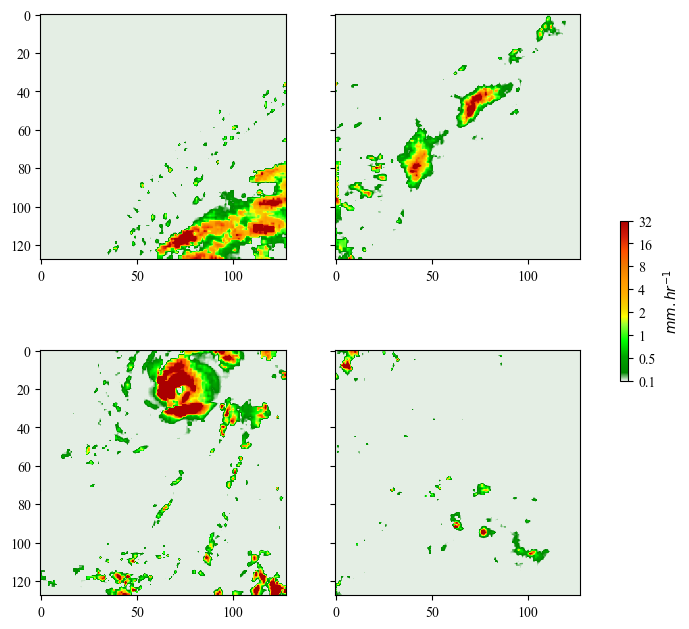

In [27]:
# plotting 2 side by side tiles.
plt.rcParams["font.size"] = 10  # global fontsize.
plt.rcParams["font.family"] = "Times New Roman"  # global font family.

plot_params = {"cmap": rain_cmap, "vmin": 1, "vmax": 8, "origin": "upper"}
cbar_params = {"orientation": "vertical", "pad": 0.1, "fraction": 0.01, "aspect": 30}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)

plt1 = axs[0, 0].imshow(imerg_patches[4, 7], **plot_params)
plt2 = axs[0, 1].imshow(imerg_patches[4, 8], **plot_params)
plt1 = axs[1, 0].imshow(imerg_patches[5, 7], **plot_params)
plt2 = axs[1, 1].imshow(imerg_patches[5, 8], **plot_params)


# # overlap patches.
# plt1 = axs[0].imshow(imerg_patches[2, 3], **plot_params)
# plt2 = axs[1].imshow(imerg_patches[2, 4], **plot_params)

# # padded patches.
# plt1 = axs[0].imshow(imerg_patches[3, 3], **plot_params)
# plt2 = axs[1].imshow(imerg_patches[3, 4], **plot_params)

plt.subplots_adjust(right=0.8)

# colour bar.
cbar_ax = fig.add_axes([0.85, 0.4, 0.01, 0.2])  # x-position, y-position, width, height
cbar = fig.colorbar(plt2, cax=cbar_ax, **cbar_params)
# harcoded cbar ticks and label.
cbar.set_label(r"$mm.hr^{-1}$")
cbar.set_ticks(np.arange(1, 9, 1))
cbar.set_ticklabels(["0.1", "0.5", "1", "2", "4", "8", "16", "32"])

### plot using a mesh instead of direct `.imshow()`

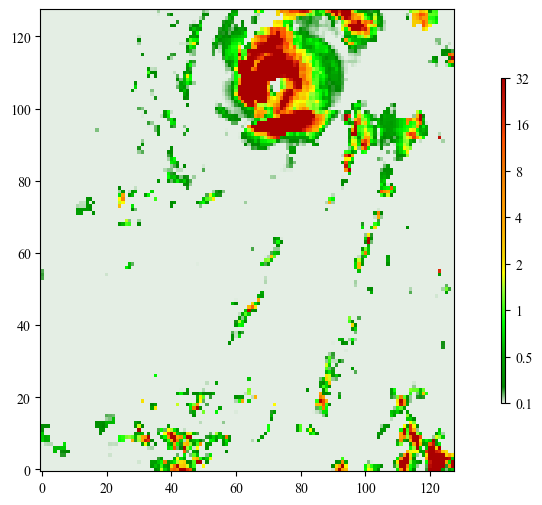

In [28]:
# plotting 2 side by side tiles.
plt.rcParams["font.size"] = 10  # global fontsize.
plt.rcParams["font.family"] = "Times New Roman"  # global font family.

plot_params = {"cmap": rain_cmap, "vmin": 1, "vmax": 8}
cbar_params = {"orientation": "vertical", "pad": 0.1, "fraction": 0.01, "aspect": 70}

fig, ax = plt.subplots(figsize=(6, 6))
xx, yy = np.float32(np.meshgrid(range(patch_size), range(patch_size)))
plot = ax.pcolormesh(xx, yy, np.flipud(imerg_patches[5, 7]), **plot_params)
# # padded patches.
# plot = ax.pcolormesh(xx, yy, np.flipud(imerg_patches[3, 3]), **plot_params)

# colour bar.
cbar = fig.colorbar(plot, ax=ax, **cbar_params)
# harcoded cbar ticks and label.
# cbar.set_label(r"$mm.hr^{-1}$")
cbar.set_ticks(np.arange(1, 9, 1))
cbar.set_ticklabels(["0.1", "0.5", "1", "2", "4", "8", "16", "32"])

plt.show()

In [29]:
# fig.savefig("images/imerg_example.png")

### Plotting an IMERG sequence.

In [30]:
def extract_imerg_hdf5_hhmm_ref_sort_key(file_name: str) -> int:
    match = re.search(r"\.(\d{4})\.V\d{2}[A-Z]\.RT-H5$", file_name)
    if match:
        return int(match.group(1))
    return 0


days = ["23", "24"]
version = "V07"

print(f"** plotting days {days} with IMERG version {version} **")

# ** get list of HDF5 filenames in a given DIR **
# root = f"data/imerg/{version}_offline_extract/2020/01"
root = f"../../data/imerg/{version}/2020/01"

data = {}
for day in days:
    files = []
    path = f"{root}/{day}/"
    pattern = re.compile(r"^3B-HHR.*\.RT-H5$")
    for file_name in os.listdir(path):
        full_path = os.path.join(path, file_name)
        if os.path.isfile(full_path) and pattern.match(file_name):
            files.append(full_path)

    files.sort(key=extract_imerg_hdf5_hhmm_ref_sort_key)
    data[day] = files

data

** plotting days ['23', '24'] with IMERG version V07 **


{'23': ['../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S000000-E002959.0000.V07B.RT-H5',
  '../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S003000-E005959.0030.V07B.RT-H5',
  '../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S010000-E012959.0060.V07B.RT-H5',
  '../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S013000-E015959.0090.V07B.RT-H5',
  '../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S020000-E022959.0120.V07B.RT-H5',
  '../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S023000-E025959.0150.V07B.RT-H5',
  '../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S030000-E032959.0180.V07B.RT-H5',
  '../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S033000-E035959.0210.V07B.RT-H5',
  '../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S040000-E042959.0240.V07B.RT-H5',
  '../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S043000-E045959.02

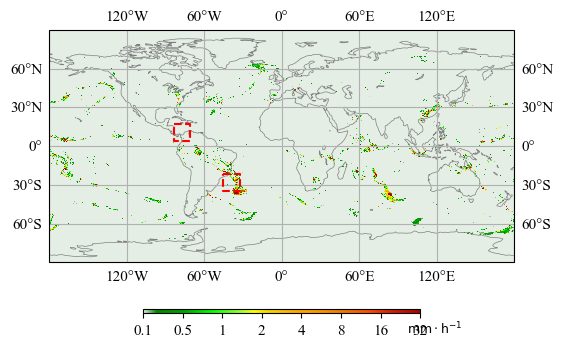

In [32]:
# lets plot one of the timesteps, non-patched.
_imerg_tile = load_imerg_h5_file_into_xarr(
    file_path=data["24"][47],
)
# apply crop:
imerg_tile = crop_xarr_using_lat_and_lon(xarr=_imerg_tile, lat_lims=lat_lims, lon_lims=lon_lims)

# plot the raw imerg tile but with geo features.
fig, ax = geoplot_raw_imerg_xarray_tile(
    imerg_tile=_imerg_tile,
    projection=ccrs.PlateCarree(),
    plot_params={"cmap": rain_cmap, "vmin": 1, "vmax": 8},
    cbar_params={
        "orientation": "horizontal",
        "pad": 0.1,
        "fraction": 0.01,
        "aspect": 60,
    },
    global_params={
        "font.size": 11,
        "font.family": "Times New Roman",
    },
    figsize=(6, 6),
    geo_params={"linewidth": 0.5},
)

# 0,0 box.
add_patch_to_geoplot(
    ax=ax,
    patch_size=PATCH_SIZE,
    lat_pixel_resolution=IMERG_PIXEL_RES,
    lon_pixel_resolution=IMERG_PIXEL_RES,
    top_left_lon_lat=(
        IMERG_CROP["inner"]["longitude"][0],
        IMERG_CROP["inner"]["latitude"][-1],
    ),
    nx=0,
    ny=0,
    box_params={"color": "red", "linestyle": "--", "linewidth": 1.5},
)

add_patch_to_geoplot(
    ax=ax,
    patch_size=PATCH_SIZE,
    lat_pixel_resolution=IMERG_PIXEL_RES,
    lon_pixel_resolution=IMERG_PIXEL_RES,
    top_left_lon_lat=(
        IMERG_CROP["inner"]["longitude"][0],
        IMERG_CROP["inner"]["latitude"][-1],
    ),
    nx=3,
    ny=3,
    box_params={"color": "red", "linestyle": "--", "linewidth": 1.5},
)

#### patching the imerg tiles to get (t, h, w, patch_h, patch_w)

In [ ]:
# lat/lon overlap required to fit tiles into crop.
x_pad = calculate_required_1d_padding(X=CROP_DIMS[0], Y=PATCH_SIZE, frac=0)
y_pad = calculate_required_1d_padding(X=CROP_DIMS[1], Y=PATCH_SIZE, frac=0)
x_pad, y_pad

(0, 0)

In [ ]:
patched = []
for k, v in data.items():
    print(f"processing {k}...")
    for fp in v:
        print(fp)
        # create imerg tile.
        imerg_tile = load_imerg_h5_file_into_xarr(file_path=fp)
        imerg_tile = crop_xarr_using_lat_and_lon(xarr=imerg_tile, lat_lims=lat_lims, lon_lims=lon_lims)
        imerg_patches = patch_2d_arr_into_nxn_squares(
            arr2d=imerg_tile,
            n=patch_size,
            x_pad=x_pad,
            y_pad=y_pad,
            flip_pixels=True,
        )
        patched.append(imerg_patches)

patched = np.array(patched)
patched.shape

processing 23...
../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S000000-E002959.0000.V07B.RT-H5
../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S003000-E005959.0030.V07B.RT-H5
../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S010000-E012959.0060.V07B.RT-H5
../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S013000-E015959.0090.V07B.RT-H5
../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S020000-E022959.0120.V07B.RT-H5
../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S023000-E025959.0150.V07B.RT-H5
../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S030000-E032959.0180.V07B.RT-H5
../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S033000-E035959.0210.V07B.RT-H5
../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S040000-E042959.0240.V07B.RT-H5
../../data/imerg/V07/2020/01/23/3B-HHR-E.MS.MRG.3IMERG.20200123-S043000-E045959.0270.V07B.RT-H5
../../data/imerg/V07/20

(96, 6, 4, 128, 128)

###  `making a GIF.`

In [ ]:
import io

i, j = 3, 3  # Replace with your actual indices
images = []
for t in range(patched.shape[0]):
    fig, ax = plt.subplots()
    ax.imshow(patched[t, i, j, :, :], **plot_params)
    ax.set_title(f"t+{t + 1}")

    # Save the figure to a BytesIO object
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)

    # Read the BytesIO object into a PIL Image
    img = Image.open(buf)
    images.append(img)
    plt.close(fig)  # Close the figure to free memory

# Save the images as a GIF
images[0].save(
    "imerg_explo.gif",
    save_all=True,
    append_images=images[1:],
    duration=100,  # duration in milliseconds between frames
    loop=0,  # loop forever
)

(<Figure size 500x500 with 1 Axes>, <Axes: >)

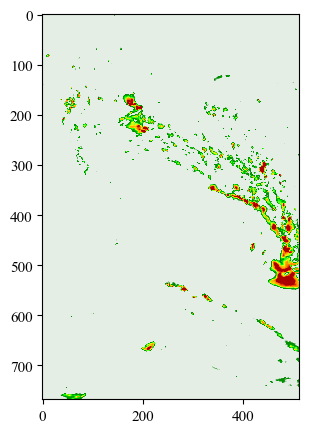

In [ ]:
# plot config.
plot_params = {"cmap": rain_cmap, "vmin": 1, "vmax": 8, "origin": "upper"}
global_params = {"font.size": 11, "font.family": "Times New Roman"}

timeslice = 0

# raw IMERG tile.
plot_raw_imerg_xarray_tile(
    imerg_tile=np.flipud(imerg_tile),
    plot_params=plot_params,
    cbar_params=None,
    global_params=global_params,
    figsize=(5, 5),
)

#### **Patchify**: overlap vs. mirror pad
* demonstrate the difference between using overlap or mirror padding when creating the patches.

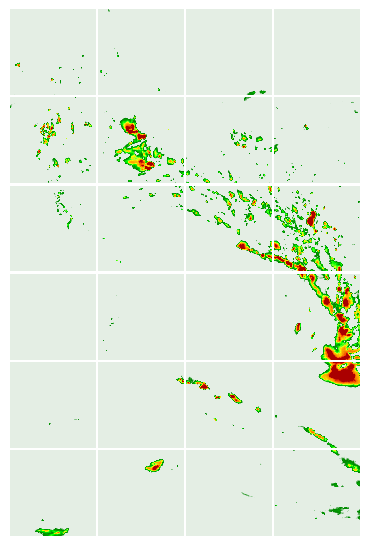

In [ ]:
patched_overlap = patch_2d_arr_into_nxn_squares(
    arr2d=imerg_tile,
    n=patch_size,
    x_pad=x_pad,
    y_pad=y_pad,
    flip_pixels=True,
)

plot_single_patched_imerg_grid(
    patched_imerg_tile=patched_overlap,
    plot_params=plot_params,
    figsize=(3.83, 5.6),
)

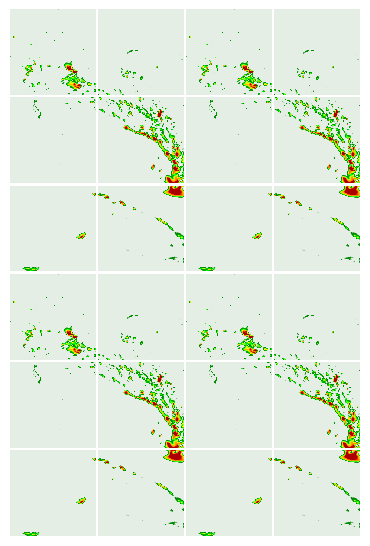

In [ ]:
patched_mirror_pad = create_square_patches_from_2d_arr_using_mirror_padding(
    arr2d=imerg_tile, patch_size=256, overlap=0, flip_pixels=True, _print=False
)

plot_single_patched_imerg_grid(
    patched_imerg_tile=patched_mirror_pad,
    plot_params=plot_params,
    figsize=(3.83, 5.6),
)

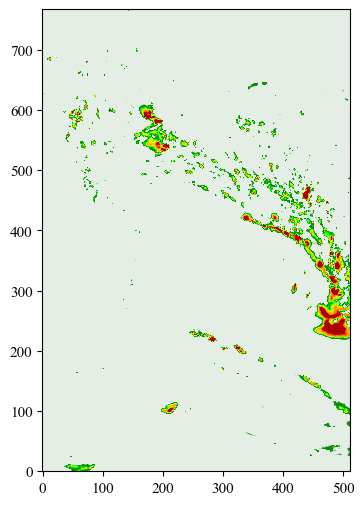

In [ ]:
# plot the raw imerg tile but with geo features.
fig, ax = plot_raw_imerg_xarray_tile(
    imerg_tile=imerg_tile,
    # projection=ccrs.PlateCarree(),
    plot_params={"cmap": rain_cmap, "vmin": 1, "vmax": 8, "origin": "lower"},
    # cbar_params={
    #     "orientation": "horizontal",
    #     "pad": 0.1,
    #     "fraction": 0.01,
    #     "aspect": 60,
    # },
    cbar_params=None,
    global_params={
        "font.size": 11,
        "font.family": "Times New Roman",
    },
    figsize=(6, 6),
)

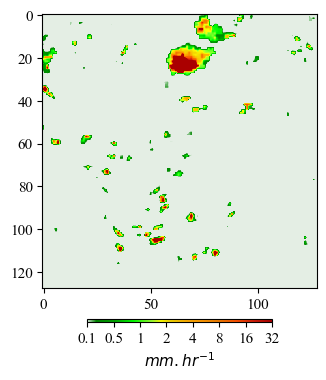

In [ ]:
timeslice_idx = 3
patch_x, patch_y = 3, 3

# plot raw imerg tile.
fig, ax = plot_raw_imerg_xarray_tile(
    imerg_tile=patched[timeslice_idx, patch_x, patch_y, :, :],
    plot_params={"cmap": rain_cmap, "vmin": 1, "vmax": 8, "origin": "upper"},
    cbar_params={
        "orientation": "horizontal",
        "pad": 0.1,
        "fraction": 0.01,
        "aspect": 60,
    },
    global_params={
        "font.size": 11,
        "font.family": "Times New Roman",
    },
    figsize=(4, 4),
)

start sequence at id: 84
Plotting the following files: ['../../data/imerg/V07/2020/01/24/3B-HHR-E.MS.MRG.3IMERG.20200124-S180000-E182959.1080.V07B.RT-H5', '../../data/imerg/V07/2020/01/24/3B-HHR-E.MS.MRG.3IMERG.20200124-S183000-E185959.1110.V07B.RT-H5', '../../data/imerg/V07/2020/01/24/3B-HHR-E.MS.MRG.3IMERG.20200124-S190000-E192959.1140.V07B.RT-H5', '../../data/imerg/V07/2020/01/24/3B-HHR-E.MS.MRG.3IMERG.20200124-S193000-E195959.1170.V07B.RT-H5', '../../data/imerg/V07/2020/01/24/3B-HHR-E.MS.MRG.3IMERG.20200124-S200000-E202959.1200.V07B.RT-H5', '../../data/imerg/V07/2020/01/24/3B-HHR-E.MS.MRG.3IMERG.20200124-S203000-E205959.1230.V07B.RT-H5', '../../data/imerg/V07/2020/01/24/3B-HHR-E.MS.MRG.3IMERG.20200124-S210000-E212959.1260.V07B.RT-H5', '../../data/imerg/V07/2020/01/24/3B-HHR-E.MS.MRG.3IMERG.20200124-S213000-E215959.1290.V07B.RT-H5', '../../data/imerg/V07/2020/01/24/3B-HHR-E.MS.MRG.3IMERG.20200124-S220000-E222959.1320.V07B.RT-H5', '../../data/imerg/V07/2020/01/24/3B-HHR-E.MS.MRG.3IME

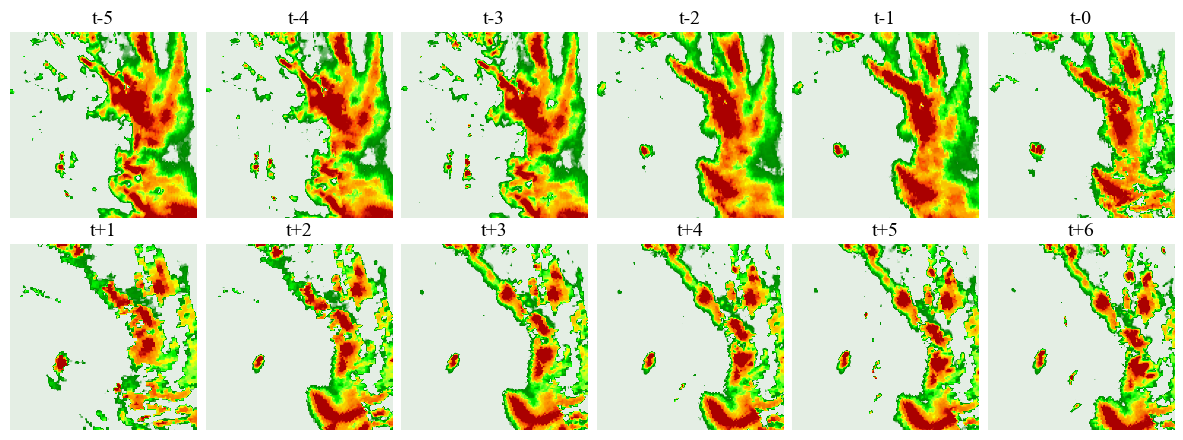

In [ ]:
# plot sequence.
sequence_len = 6
target_len = 6
start_idx = len(patched) - sequence_len - target_len
print(f"start sequence at id: {start_idx}")
print(f"Plotting the following files: {[t for t in data['24']][-(sequence_len + target_len): ]}")
patch_x, patch_y = 3, 3

inputs = patched[start_idx : start_idx + sequence_len, patch_x, patch_y, :, :]
targets = patched[
    (start_idx + sequence_len) : (start_idx + sequence_len) + target_len,
    patch_x,
    patch_y,
    :,
    :,
]

plt.rcParams["font.size"] = 12  # global fontsize.
plt.rcParams["font.family"] = "Times New Roman"  # global font family.

plot_params = {"cmap": rain_cmap, "vmin": 1, "vmax": 8, "origin": "upper"}

fig, axs = plt.subplots(2, sequence_len, figsize=(12, 4.5))
for i in range(sequence_len):

    axs[0, i].imshow(inputs[i], **plot_params)
    axs[0, i].set_title(f"t-{sequence_len - i - 1}")
    axs[0, i].axis("off")

    # add target sequence at offset.
    if i >= (sequence_len - target_len):
        axs[1, i].imshow(targets[i - (sequence_len - target_len)], **plot_params)
        axs[1, i].set_title(f"t+{i-(sequence_len - target_len) + 1}")
    axs[1, i].axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)

### `Compare Early-Run to Final-Run Half-hourly`

In [ ]:
def extract_imerg_hdf5_hhmm_ref_sort_key(file_name: str) -> int:
    match = re.search(r"\.(\d{4})\.V\d{2}[A-Z]\.HDF5$", file_name)
    if match:
        return int(match.group(1))
    return 0


# comparison to downloaded directly from online.
# path = "../data/imerg/early_run_direct"
path = "/Volumes/external_disk_seal/data/GPM/RS/V07/IMERG/IMERG-FR/2020/01/24"
files = []
pattern = re.compile(r"^3B-HHR.*\.HDF5$")
for file_name in os.listdir(path):
    full_path = os.path.join(path, file_name)
    if os.path.isfile(full_path) and pattern.match(file_name):
        files.append(full_path)
files.sort(key=extract_imerg_hdf5_hhmm_ref_sort_key)
patched_test = []
for fp in files:
    print(fp)
    # create imerg tile.
    imerg_tile = load_imerg_h5_file_into_xarr(file_path=fp)
    imerg_tile = crop_xarr_using_lat_and_lon(xarr=imerg_tile, lat_lims=lat_lims, lon_lims=lon_lims)
    imerg_patches = patch_2d_arr_into_nxn_squares(
        arr2d=imerg_tile,
        n=patch_size,
        x_pad=x_pad,
        y_pad=y_pad,
        flip_pixels=True,
    )
    patched_test.append(imerg_patches)

patched_test = np.array(patched_test)
patched_test.shape

/Volumes/external_disk_seal/data/GPM/RS/V07/IMERG/IMERG-FR/2020/01/24/3B-HHR.MS.MRG.3IMERG.20200124-S000000-E002959.0000.V07B.HDF5
/Volumes/external_disk_seal/data/GPM/RS/V07/IMERG/IMERG-FR/2020/01/24/3B-HHR.MS.MRG.3IMERG.20200124-S003000-E005959.0030.V07B.HDF5
/Volumes/external_disk_seal/data/GPM/RS/V07/IMERG/IMERG-FR/2020/01/24/3B-HHR.MS.MRG.3IMERG.20200124-S010000-E012959.0060.V07B.HDF5
/Volumes/external_disk_seal/data/GPM/RS/V07/IMERG/IMERG-FR/2020/01/24/3B-HHR.MS.MRG.3IMERG.20200124-S013000-E015959.0090.V07B.HDF5
/Volumes/external_disk_seal/data/GPM/RS/V07/IMERG/IMERG-FR/2020/01/24/3B-HHR.MS.MRG.3IMERG.20200124-S020000-E022959.0120.V07B.HDF5
/Volumes/external_disk_seal/data/GPM/RS/V07/IMERG/IMERG-FR/2020/01/24/3B-HHR.MS.MRG.3IMERG.20200124-S023000-E025959.0150.V07B.HDF5
/Volumes/external_disk_seal/data/GPM/RS/V07/IMERG/IMERG-FR/2020/01/24/3B-HHR.MS.MRG.3IMERG.20200124-S030000-E032959.0180.V07B.HDF5
/Volumes/external_disk_seal/data/GPM/RS/V07/IMERG/IMERG-FR/2020/01/24/3B-HHR.MS.MRG

(48, 6, 4, 128, 128)

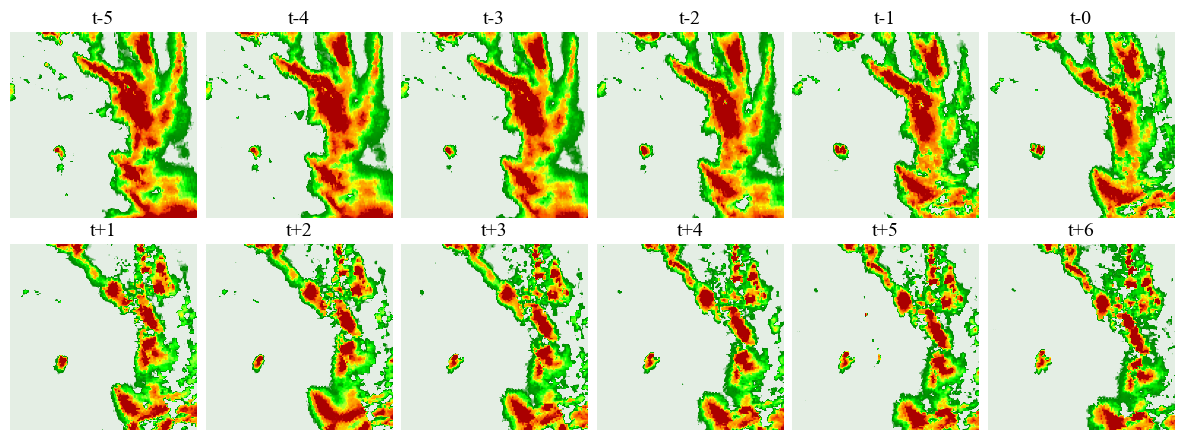

In [ ]:
# plot sequence.
sequence_len = 6
target_len = 6
start_idx = len(patched_test) - sequence_len - target_len

inputs = patched_test[start_idx : start_idx + sequence_len, patch_x, patch_y, :, :]
targets = patched_test[
    (start_idx + sequence_len) : (start_idx + sequence_len) + target_len,
    patch_x,
    patch_y,
    :,
    :,
]

plt.rcParams["font.size"] = 12  # global fontsize.
plt.rcParams["font.family"] = "Times New Roman"  # global font family.

plot_params = {"cmap": rain_cmap, "vmin": 1, "vmax": 8, "origin": "upper"}

fig, axs = plt.subplots(2, sequence_len, figsize=(12, 4.5))
for i in range(sequence_len):

    axs[0, i].imshow(inputs[i], **plot_params)
    axs[0, i].set_title(f"t-{sequence_len - i - 1}")
    axs[0, i].axis("off")

    # add target sequence at offset.
    if i >= (sequence_len - target_len):
        axs[1, i].imshow(targets[i - (sequence_len - target_len)], **plot_params)
        axs[1, i].set_title(f"t+{i-(sequence_len - target_len) + 1}")
    axs[1, i].axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)

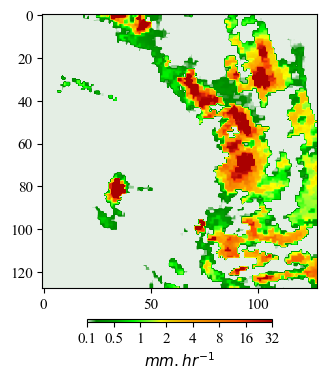

In [ ]:
# create imerg tile.
imerg_tile = load_imerg_h5_file_into_xarr(
    file_path="../../data/imerg/early_run_direct/3B-HHR-E.MS.MRG.3IMERG.20200124-S210000-E212959.1260.V07B.HDF5"
    # file_path="/Volumes/external_disk_seal/data/GPM/RS/V07/IMERG/IMERG-FR/2020/01/24/3B-HHR.MS.MRG.3IMERG.20200124-S210000-E212959.1260.V07B.HDF5"
)
imerg_tile = crop_xarr_using_lat_and_lon(xarr=imerg_tile, lat_lims=lat_lims, lon_lims=lon_lims)
imerg_patches = patch_2d_arr_into_nxn_squares(
    arr2d=imerg_tile,
    n=patch_size,
    x_pad=x_pad,
    y_pad=y_pad,
    flip_pixels=True,
)

# plot raw imerg tile.
fig, ax = plot_raw_imerg_xarray_tile(
    imerg_tile=imerg_patches[patch_x, patch_y, :, :],
    plot_params={"cmap": rain_cmap, "vmin": 1, "vmax": 8, "origin": "upper"},
    cbar_params={
        "orientation": "horizontal",
        "pad": 0.1,
        "fraction": 0.01,
        "aspect": 60,
    },
    global_params={
        "font.size": 11,
        "font.family": "Times New Roman",
    },
    figsize=(4, 4),
)

**Comments:**

* This particular image in the early-run product looks to be "missing" data when compared to the final-run. 

* This is likely an artefact of the early-run product not having gone through extra data processing such as data assimilation.

### END OF SCRIPT.